# Compare anonymization algorithms

In this notebook, we implement K-anonymization algorithms: ML anonymization module and Mondrian (+l-diverse), and differential privacy. 

We will demonstrate running membership inference attacks both on a vanilla model, and then on an anonymized versions of the model. We use ART's inference module (https://github.com/Trusted-AI/adversarial-robustness-toolbox/tree/main/art/attacks/inference). 

This will be demonstarted using the Adult dataset (original dataset can be found here: https://archive.ics.uci.edu/ml/datasets/adult).

For simplicity, we used only the numerical features in the dataset.

## Load data

In [1]:
import numpy as np

# Use only numeric features (age, education-num, capital-gain, capital-loss, hours-per-week)
x_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ")

y_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=", ")


x_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=", ", skiprows=1)

# Trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

y_train[y_train == '<=50K'] = 0
y_train[y_train == '>50K'] = 1
y_train = y_train.astype(np.int)

y_test[y_test == '<=50K'] = 0
y_test[y_test == '>50K'] = 1
y_test = y_test.astype(np.int)

# get balanced dataset
x_train = x_train[:x_test.shape[0]]
y_train = y_train[:y_test.shape[0]]

<ipython-input-1-28aee2c1f2be>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = y_train.astype(np.int)
<ipython-input-1-28aee2c1f2be>:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for mor

## Train decision tree model

In [2]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

art_classifier = ScikitlearnDecisionTreeClassifier(model)
acc_base = model.score(x_test, y_test)
print('Base model accuracy: ', acc_base)

x_train_predictions = np.array([np.argmax(arr) for arr in art_classifier.predict(x_train)]).reshape(-1,1)

Base model accuracy:  0.8090412136846631


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Attack
The black-box attack basically trains an additional classifier (called the attack model) to predict the membership status of a sample.
#### Train attack model

In [3]:
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox

# attack_model_type can be nn (neural network), rf (randon forest) or gb (gradient boosting)
bb_attack = MembershipInferenceBlackBox(art_classifier, attack_model_type='rf')

# use half of each dataset for training the attack
attack_train_ratio = 0.5
attack_train_size = int(len(x_train) * attack_train_ratio)
attack_test_size = int(len(x_test) * attack_train_ratio)

# train attack model
bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
              x_test[:attack_test_size], y_test[:attack_test_size])

#### Infer sensitive feature and check accuracy

In [4]:
# get inferred values for remaining half
inferred_train_bb = bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
inferred_test_bb = bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
train_acc = np.sum(inferred_train_bb) / len(inferred_train_bb)
test_acc = 1 - (np.sum(inferred_test_bb) / len(inferred_test_bb))
member_attack_acc = (train_acc * len(inferred_train_bb) + test_acc * len(inferred_test_bb)) / (len(inferred_train_bb) + len(inferred_test_bb))
print(member_attack_acc)

0.5434221840068788


This means that for 54% of the data, membership is inferred correctly using this attack.

# Anonymized data
## k=100

Now we will apply the same attacks on an anonymized versions (ML anonymization module, Mondrian and differential privacy) of the same dataset (k=100). The data is anonymized on the quasi-identifiers: age, education-num, capital-gain, hours-per-week.

k=100 means that each record in the anonymized dataset is identical to 99 others on the quasi-identifier values (i.e., when looking only at those features, the records are indistinguishable).

###  ML anonymization module

In [5]:
from apt.utils.datasets import ArrayDataset
from apt.anonymization import Anonymize

k = 100

# QI = (age, education-num, capital-gain, hours-per-week)
QI = [0, 1, 2, 4]

anonymizer = Anonymize(k, QI)
anon = anonymizer.anonymize(ArrayDataset(x_train, x_train_predictions))
print(anon)

[[38. 13.  0.  0. 40.]
 [46. 13.  0.  0. 35.]
 [28.  9.  0.  0. 40.]
 ...
 [26. 13.  0.  0. 40.]
 [27. 10.  0.  0. 50.]
 [28.  9.  0.  0. 40.]]


In [6]:
# number of distinct rows in original data
len(np.unique(x_train, axis=0))

6739

In [7]:
# number of distinct rows in anonymized data
len(np.unique(anon, axis=0))

401

#### Train decision tree model

In [8]:
anon_model = DecisionTreeClassifier()
anon_model.fit(anon, y_train)

anon_art_classifier = ScikitlearnDecisionTreeClassifier(anon_model)
acc_anon_ML = anon_model.score(x_test, y_test)
print('Anonymized model accuracy: ', acc_anon_ML)

Anonymized model accuracy:  0.8266691235182114


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


####  Attack
##### Black-box attack

In [9]:
anon_bb_attack = MembershipInferenceBlackBox(anon_art_classifier, attack_model_type='rf')

# train attack model
anon_bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
                   x_test[:attack_test_size], y_test[:attack_test_size])

# get inferred values
anon_inferred_train_bb = anon_bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
anon_inferred_test_bb = anon_bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
anon_train_acc = np.sum(anon_inferred_train_bb) / len(anon_inferred_train_bb)
anon_test_acc = 1 - (np.sum(anon_inferred_test_bb) / len(anon_inferred_test_bb))
anon_attkacc_ML = (anon_train_acc * len(anon_inferred_train_bb) + anon_test_acc * len(anon_inferred_test_bb)) / (len(anon_inferred_train_bb) + len(anon_inferred_test_bb))
print(anon_attkacc_ML)

0.4961306964746346


Attack accuracy is reduced to 50% (eqiuvalent to random guessing)

###  Mondrian

In [10]:
from mondrian import anonymize, MondrianOption

sensitive_column = (set(range(min(QI), max(QI))) - set(QI)).pop()
categorical = set(())

anon = anonymize(x_train, categorical, QI, sensitive_column, k, MondrianOption.Non)
print(anon)

               0          1            2    3          4
0      38.580808  13.439394  1852.419192  0.0  40.065657
1      55.341969  12.051813  1245.590674  0.0  27.735751
2      38.000000   9.000000   159.293578  0.0  46.183486
3      50.855556   5.172222   184.983333  0.0  45.477778
4      28.450777  13.378238   414.616580  0.0  47.041451
...          ...        ...          ...  ...        ...
16276  24.492308   9.000000   308.820513  0.0  42.574359
16277  34.981651  10.000000   879.339450  0.0  45.706422
16278  26.531792  13.265896   880.254335  0.0  45.231214
16279  25.862661  11.416309   758.424893  0.0  44.175966
16280  27.046154   9.000000   550.892308  0.0  43.849231

[16281 rows x 5 columns]


In [11]:
# number of distinct rows in anonymized data
len(np.unique(anon, axis=0))

670

#### Train decision tree model

In [12]:
anon_model = DecisionTreeClassifier()
anon_model.fit(anon, y_train)

anon_art_classifier = ScikitlearnDecisionTreeClassifier(anon_model)

acc_anon_mondrian = anon_model.score(x_test, y_test)
print('Anonymized model accuracy: ', acc_anon_mondrian)

Anonymized model accuracy:  0.8091640562619004


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


####  Attack
##### Black-box attack

In [13]:
anon_bb_attack = MembershipInferenceBlackBox(anon_art_classifier, attack_model_type='rf')

# train attack model
anon_bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
                   x_test[:attack_test_size], y_test[:attack_test_size])

# get inferred values
anon_inferred_train_bb = anon_bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
anon_inferred_test_bb = anon_bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
anon_train_acc = np.sum(anon_inferred_train_bb) / len(anon_inferred_train_bb)
anon_test_acc = 1 - (np.sum(anon_inferred_test_bb) / len(anon_inferred_test_bb))
anon_attkacc_mondrian = (anon_train_acc * len(anon_inferred_train_bb) + anon_test_acc * len(anon_inferred_test_bb)) / (len(anon_inferred_train_bb) + len(anon_inferred_test_bb))
print(anon_attkacc_mondrian)

0.5036236334602628


###  l-diversity l=2

In [14]:
anon = anonymize(x_train, categorical, QI, sensitive_column, k, MondrianOption.ldiv, 2)
print(anon)

               0          1            2    3          4
0      38.580808  13.439394  1852.419192  0.0  40.065657
1      55.341969  12.051813  1245.590674  0.0  27.735751
2      38.000000   9.000000   159.293578  0.0  46.183486
3      50.855556   5.172222   184.983333  0.0  45.477778
4      28.450777  13.378238   414.616580  0.0  47.041451
...          ...        ...          ...  ...        ...
16276  24.492308   9.000000   308.820513  0.0  42.574359
16277  34.981651  10.000000   879.339450  0.0  45.706422
16278  26.531792  13.265896   880.254335  0.0  45.231214
16279  25.862661  11.416309   758.424893  0.0  44.175966
16280  27.046154   9.000000   550.892308  0.0  43.849231

[16281 rows x 5 columns]


In [15]:
# number of distinct rows in anonymized data
len(np.unique(anon, axis=0))

670

#### Train decision tree model

In [17]:
anon_model = DecisionTreeClassifier()
anon_model.fit(anon, y_train)

anon_art_classifier = ScikitlearnDecisionTreeClassifier(anon_model)

acc_anon_ldiv = anon_model.score(x_test, y_test)  
print('Anonymized model accuracy: ', acc_anon_ldiv)

Anonymized model accuracy:  0.8098396904367053


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


####  Attack
##### Black-box attack

In [18]:
anon_bb_attack = MembershipInferenceBlackBox(anon_art_classifier, attack_model_type='rf')

# train attack model
anon_bb_attack.fit(x_train[:attack_train_size], y_train[:attack_train_size],
                   x_test[:attack_test_size], y_test[:attack_test_size])

# get inferred values
anon_inferred_train_bb = anon_bb_attack.infer(x_train[attack_train_size:], y_train[attack_train_size:])
anon_inferred_test_bb = anon_bb_attack.infer(x_test[attack_test_size:], y_test[attack_test_size:])
# check accuracy
anon_train_acc = np.sum(anon_inferred_train_bb) / len(anon_inferred_train_bb)
anon_test_acc = 1 - (np.sum(anon_inferred_test_bb) / len(anon_inferred_test_bb))
anon_attkacc_ldiv = (anon_train_acc * len(anon_inferred_train_bb) + anon_test_acc * len(anon_inferred_test_bb)) / (len(anon_inferred_train_bb) + len(anon_inferred_test_bb))
print(anon_attkacc_ldiv)

0.49803463947917953


##  Differential privacy
epsilon = 75

In [19]:
import diffprivlib.models as dp
from art.estimators.classification.scikitlearn import ScikitlearnDecisionTreeClassifier

dp_model = dp.DecisionTreeClassifier(epsilon=5, data_norm=5)
dp_model.fit(x_train, y_train)
# print('norm: ', np.linalg.norm(x_train) )

dp_art_model = ScikitlearnDecisionTreeClassifier(dp_model)
acc_dp = dp_model.score(x_test, y_test)
print('DP model accuracy: ', acc_dp)

DP model accuracy:  0.7736011301517106


/anonym/diffprivlib/utils.py:71: DiffprivlibCompatibilityWarning: Parameter 'data_norm' is not functional in diffprivlib.  Remove this parameter to suppress this warning.
  warnings.warn(f"Parameter '{arg}' is not functional in diffprivlib.  Remove this parameter to suppress this "
/anonym/diffprivlib/models/forest.py:419: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/anonym/diffprivlib/models/forest.py:427: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have 

####  Attack
##### Black-box attack

In [20]:
dp_attack = MembershipInferenceBlackBox(dp_art_model, attack_model_type='rf')

# train attack model
dp_attack.fit(x_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size],
              x_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size])

# infer 
dp_inferred_train = dp_attack.infer(x_train.astype(np.float32)[attack_train_size:], y_train[attack_train_size:])
dp_inferred_test = dp_attack.infer(x_test.astype(np.float32)[attack_test_size:], y_test[attack_test_size:])

# check accuracy
dp_train_acc = np.sum(dp_inferred_train) / len(dp_inferred_train)
dp_test_acc = 1 - (np.sum(dp_inferred_test) / len(dp_inferred_test))
dp_attkacc = (dp_train_acc * len(dp_inferred_train) + dp_test_acc * len(dp_inferred_test)) / (len(dp_inferred_train) + len(dp_inferred_test))
print(dp_attkacc)

0.5003070875813782


## Comparison

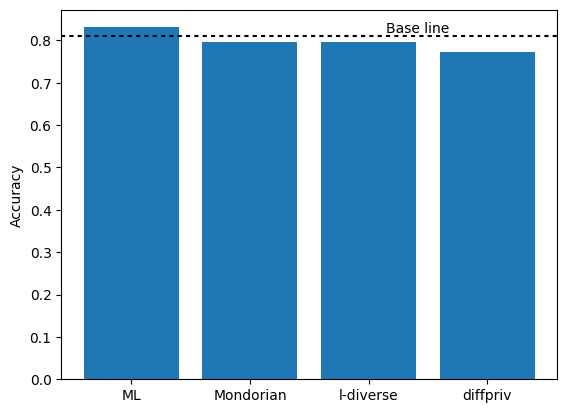

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

algorithm = ['ML', 'Mondorian', 'l-diverse', 'diffpriv']

plt.bar(algorithm, [acc_anon_ML, acc_anon_mondrian, acc_anon_ldiv, acc_dp])
plt.axhline(y=acc_base, dashes=[2,2], color='black')
plt.text(2.15, acc_base+0.01, 'Base line')

plt.ylabel('Accuracy')

plt.show()

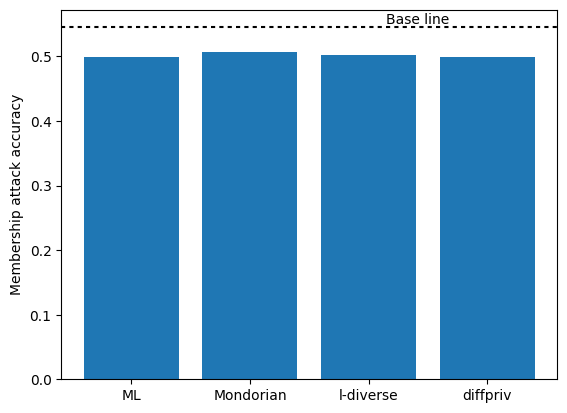

In [21]:
plt.bar(algorithm, [anon_attkacc_ML, anon_attkacc_mondrian, anon_attkacc_ldiv, dp_attkacc])
plt.axhline(y=member_attack_acc, dashes=[2,2], color='black')
plt.text(2.15, member_attack_acc+0.005, 'Base line')

plt.ylabel('Membership attack accuracy')

plt.show()